# Commands

```
./analyze_ng50.py mqc500.coords mircea.rm13.fa  > mqc.ng50.txt
./analyze_ng50.py iqc500.coords mircea.rm13.fa  > iqc.ng50.txt
./analyze_ng50.py sqc500.coords mircea.rm13.fa  > sqc.ng50.txt
```

In [59]:
%matplotlib inline
import pylab
import pandas
import matplotlib.pyplot as pyplot
import nicenames

pyplot.style.use('seaborn-darkgrid') # I like 'fivethirtyeight'

In [41]:
ls *ng50.txt

iqc.ng50.txt  mqc.ng50.txt  sqc.ng50.txt


In [56]:
def load_ng50(filename):
    x = []
    for line in open(filename):
        line = line.strip().split(',', 2)
        ng50, ng90, name = line
        ng50 = float(ng50)
        ng90 = float(ng90)
        x.append((ng50, ng90, name))
    return x

iqc = pandas.DataFrame(load_ng50('iqc.ng50.txt'))
mqc = pandas.DataFrame(load_ng50('mqc.ng50.txt'))
sqc = pandas.DataFrame(load_ng50('sqc.ng50.txt'))

iqc.columns = ['idba_ng50', 'drop', 'nicename']
mqc.columns = ['megahit_ng50', 'drop', 'nicename']
sqc.columns = ['spades_ng50', 'drop', 'nicename']

iqc = iqc.drop('drop', axis=1)
mqc = mqc.drop('drop', axis=1)
sqc = sqc.drop('drop', axis=1)

combined = pandas.DataFrame(iqc)
combined = combined.merge(sqc, on=['nicename'])
combined = combined.merge(mqc, on=['nicename'])
combined = combined.ix[:, ['nicename', 'idba_ng50', 'spades_ng50', 'megahit_ng50']]

nga50_df = combined

nga50_df = nga50_df.sort_values(by='megahit_ng50', ascending=True)
nga50_df = nga50_df.reset_index(drop=True)
nga50_df[:5]

,nicename,idba_ng50,spades_ng50,megahit_ng50
0,Sulfurihydrogenibium yellowstonense SS-5,1618.0,1644.0,2691.0
1,Sulfitobacter sp. EE-36,2606.0,7040.0,4039.0
2,Sulfitobacter NAS-14.1,2780.0,7496.0,4350.0
3,Sulfurihydrogenibium sp. YO3AOP1,6380.0,19311.0,4854.0
4,Shewanella baltica OS185,6656.0,5494.0,5100.0


In [57]:
idba_lowest = nga50_df[(nga50_df.idba_ng50 < nga50_df.spades_ng50) & (nga50_df.idba_ng50 < nga50_df.megahit_ng50)]
spades_highest = nga50_df[(nga50_df.spades_ng50 > nga50_df.idba_ng50) & (nga50_df.spades_ng50 > nga50_df.megahit_ng50)]
        
print('spades highest', len(spades_highest))
print('idba lowest', len(idba_lowest))

spades highest 33
idba lowest 30


In [83]:
def load_aligncov(filename):
    for line in open(filename):
        genome, cov, total, f_cov = line.strip().split()
        cov = int(float(cov))
        total = int(float(total))
        f_cov = float(f_cov)
        if f_cov == 0.0:
            #print('skipping', genome, nicenames.nicenames[genome])
            continue
        yield genome, cov, total, f_cov
        
iqc = list(load_aligncov('all-iqc-aligncov.txt'))
mqc = list(load_aligncov('all-mqc-aligncov.txt'))
sqc = list(load_aligncov('all-sqc-aligncov.txt'))

def cleanup(df):
    df['nicename'] = df['genome']
    df = df.replace({'nicename': nicenames.nicenames })
    df = df.drop('cov', axis=1)
    df = df.drop('total', axis=1)
    
    return df

idf = pandas.DataFrame(iqc, columns=['genome', 'cov', 'total', 'idba_cov'])
mdf = pandas.DataFrame(mqc, columns=['genome', 'cov', 'total', 'megahit_cov'])
sdf = pandas.DataFrame(sqc, columns=['genome', 'cov', 'total', 'spades_cov'])

idf = cleanup(idf)
mdf = cleanup(mdf)
sdf = cleanup(sdf)

combined = pandas.concat([idf, sdf, mdf], join='inner', axis=1)
combined.columns = ['genome', 'idba_cov', 'nicename', 'drop', 'spades_cov', 'drop', 'drop', 'megahit_cov', 'drop']

combined = combined.drop('drop', axis=1)
combined = combined.drop('genome', axis=1)

combined = combined.ix[:, ['nicename', 'idba_cov', 'spades_cov', 'megahit_cov']]
cov_df = combined
cov_df[:5]
print(len(cov_df))

51


In [77]:
big_df = cov_df.merge(nga50_df, on=['nicename'])
print(len(big_df))
big_df[:5]

51


,nicename,idba_cov,spades_cov,megahit_cov,idba_ng50,spades_ng50,megahit_ng50
0,Acidobacterium capsulatum ATCC 51196,0.994556,0.994782,0.995594,143087.0,199595.0,152481.0
1,Chlorobium limicola,0.967738,0.969488,0.973936,91974.0,100747.0,94466.0
2,Chlorobium phaeobacteroides,0.941313,0.949237,0.951151,40856.0,40768.0,40595.0
3,Chlorobiumphaeo vibrioides DSM 265,0.991616,0.992015,0.993620,251876.0,177554.0,251975.0
4,Chlorobium tepidum,0.993674,0.992868,0.997156,103278.0,139137.0,130936.0


In [98]:
strain_labels = {}
for name in big_df.nicename:
    if nicenames.is_strain(name):
        strain_labels[name] = name + '$^*$'
    else:
        strain_labels[name] = name
        
big_df['strainfoo'] = big_df['nicename'].map(strain_labels)
big_df[:20]

,nicename,idba_cov,spades_cov,megahit_cov,idba_ng50,spades_ng50,megahit_ng50,strainfoo
0,Persephonella marina EX-H1,0.999809,0.994748,0.999729,549093.0,987376.0,987438.0,Persephonella marina EX-H1
1,Nanoarchaeum equitans Kin4-M,0.995471,0.995410,0.995471,474066.0,474022.0,474084.0,Nanoarchaeum equitans Kin4-M
2,Gemmatimonas aurantiaca T-27 DNA,0.999141,0.999583,0.999374,373358.0,391891.0,344595.0,Gemmatimonas aurantiaca T-27 DNA
3,Chlorobiumphaeo vibrioides DSM 265,0.991616,0.992015,0.993620,251876.0,177554.0,251975.0,Chlorobiumphaeo vibrioides DSM 265
4,Methanopyrus kandleri AV19,0.999750,0.999255,0.999612,223403.0,935745.0,248463.0,Methanopyrus kandleri AV19
5,Pyrobaculum calidifontis JCM 11548,0.997865,0.996517,0.998021,135900.0,221757.0,171373.0,Pyrobaculum calidifontis JCM 11548
6,Geobacter sulfurreducens PCA,0.988354,0.988993,0.989239,125501.0,161888.0,168426.0,Geobacter sulfurreducens PCA
7,Rhodopirellula baltica SH 1,0.990188,0.990763,0.991804,220154.0,198450.0,153187.0,Rhodopirellula baltica SH 1
8,Acidobacterium capsulatum ATCC 51196,0.994556,0.994782,0.995594,143087.0,199595.0,152481.0,Acidobacterium capsulatum ATCC 51196
9,Hydrogenobaculum sp. Y04AAS1,0.994419,0.997669,0.994052,129866.0,202727.0,148135.0,Hydrogenobaculum sp. Y04AAS1


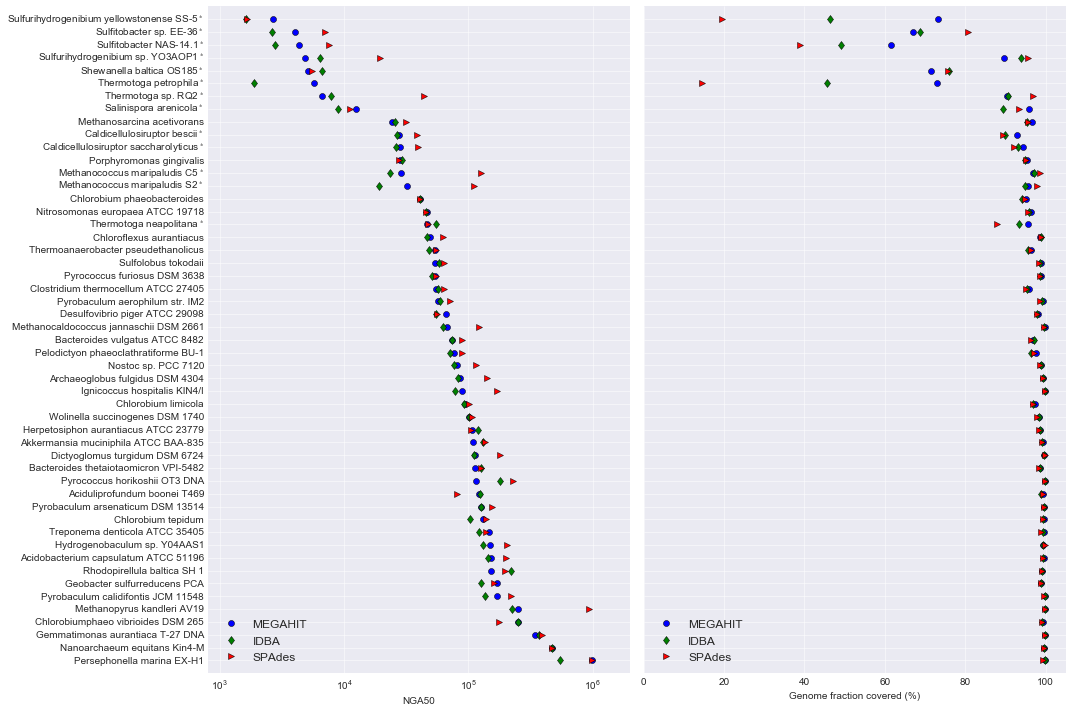

In [124]:
def plot_coverage(df, ax):
    ax.plot(df.megahit_cov * 100., range(len(df)), 'o', label='MEGAHIT')
    ax.plot(df.idba_cov * 100., range(len(df)), 'd', label='IDBA')
    ax.plot(df.spades_cov * 100., range(len(df)), '>', label='SPAdes')

    ax.yaxis.set_ticks(range(max_y))
    ax.yaxis.set_ticklabels([])
    ax.set_xlim([0, 105])

    ax.set_xlabel('Genome fraction covered (%)')
    ax.legend(loc='lower left')
    
def plot_nga50(df, ax):
    ax.plot(df.megahit_ng50, range(len(df)), 'o', label='MEGAHIT')
    ax.plot(df.idba_ng50, range(len(df)), 'd', label='IDBA')
    ax.plot(df.spades_ng50, range(len(df)), '>', label='SPAdes')
    

    ax.yaxis.set_ticks(range(max_y))
    ax.yaxis.set_ticklabels(df.strainfoo)
                    
    ax.set_xscale('log')
    ax.set_xlim([8e2, 2e6])

    ax.set_xlabel('NGA50')
    ax.legend(loc='lower left')
    
big_df = big_df.sort_values(by='megahit_ng50', ascending=False)
big_df = big_df.reset_index(drop=True)

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 10))
plot_nga50(big_df, axes[0])
plot_coverage(big_df, axes[1])
for ax in axes:
    ax.set_ylim([-1, len(big_df)])
    
#pyplot.subplots_adjust(left=0.5)
pyplot.sca(axes[0])
ytickNames = pyplot.setp(subp, yticklabels=big_df.strainfoo)
pyplot.setp(ytickNames, fontsize=10)

pyplot.tight_layout()
    
pyplot.savefig('combined.pdf')
pyplot.savefig('combined.png')